In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 71 (delta 12), reused 8 (delta 8), pack-reused 57
Receiving objects: 100% (71/71), 172.08 KiB | 3.13 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [2]:
cd lag-llama

/content/lag-llama


In [3]:
!pip install -r requirements.txt --quiet # this could take some time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. 

In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /root/.cache/huggingface/hub/tmp4rmzdeju
lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 139MB/s] 
/content/lag-llama/lag-llama.ckpt


In [5]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from lag_llama.gluon.estimator import LagLlamaEstimator

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [19]:
import pandas as pd

In [33]:
dataset = get_dataset("australian_electricity_demand")

backtest_dataset = dataset.test
prediction_length = dataset.metadata.prediction_length
context_length = 32

In [34]:
ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cuda:0'))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

In [35]:
estimator = LagLlamaEstimator(
    ckpt_path="lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,

    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
)

lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

In [36]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=predictor,
)

In [37]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [38]:
evaluator = Evaluator()

In [39]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 5it [00:00, 216.37it/s]


In [40]:
print("CRPS:", agg_metrics['mean_wQuantileLoss'])

CRPS: 0.07416629137878367


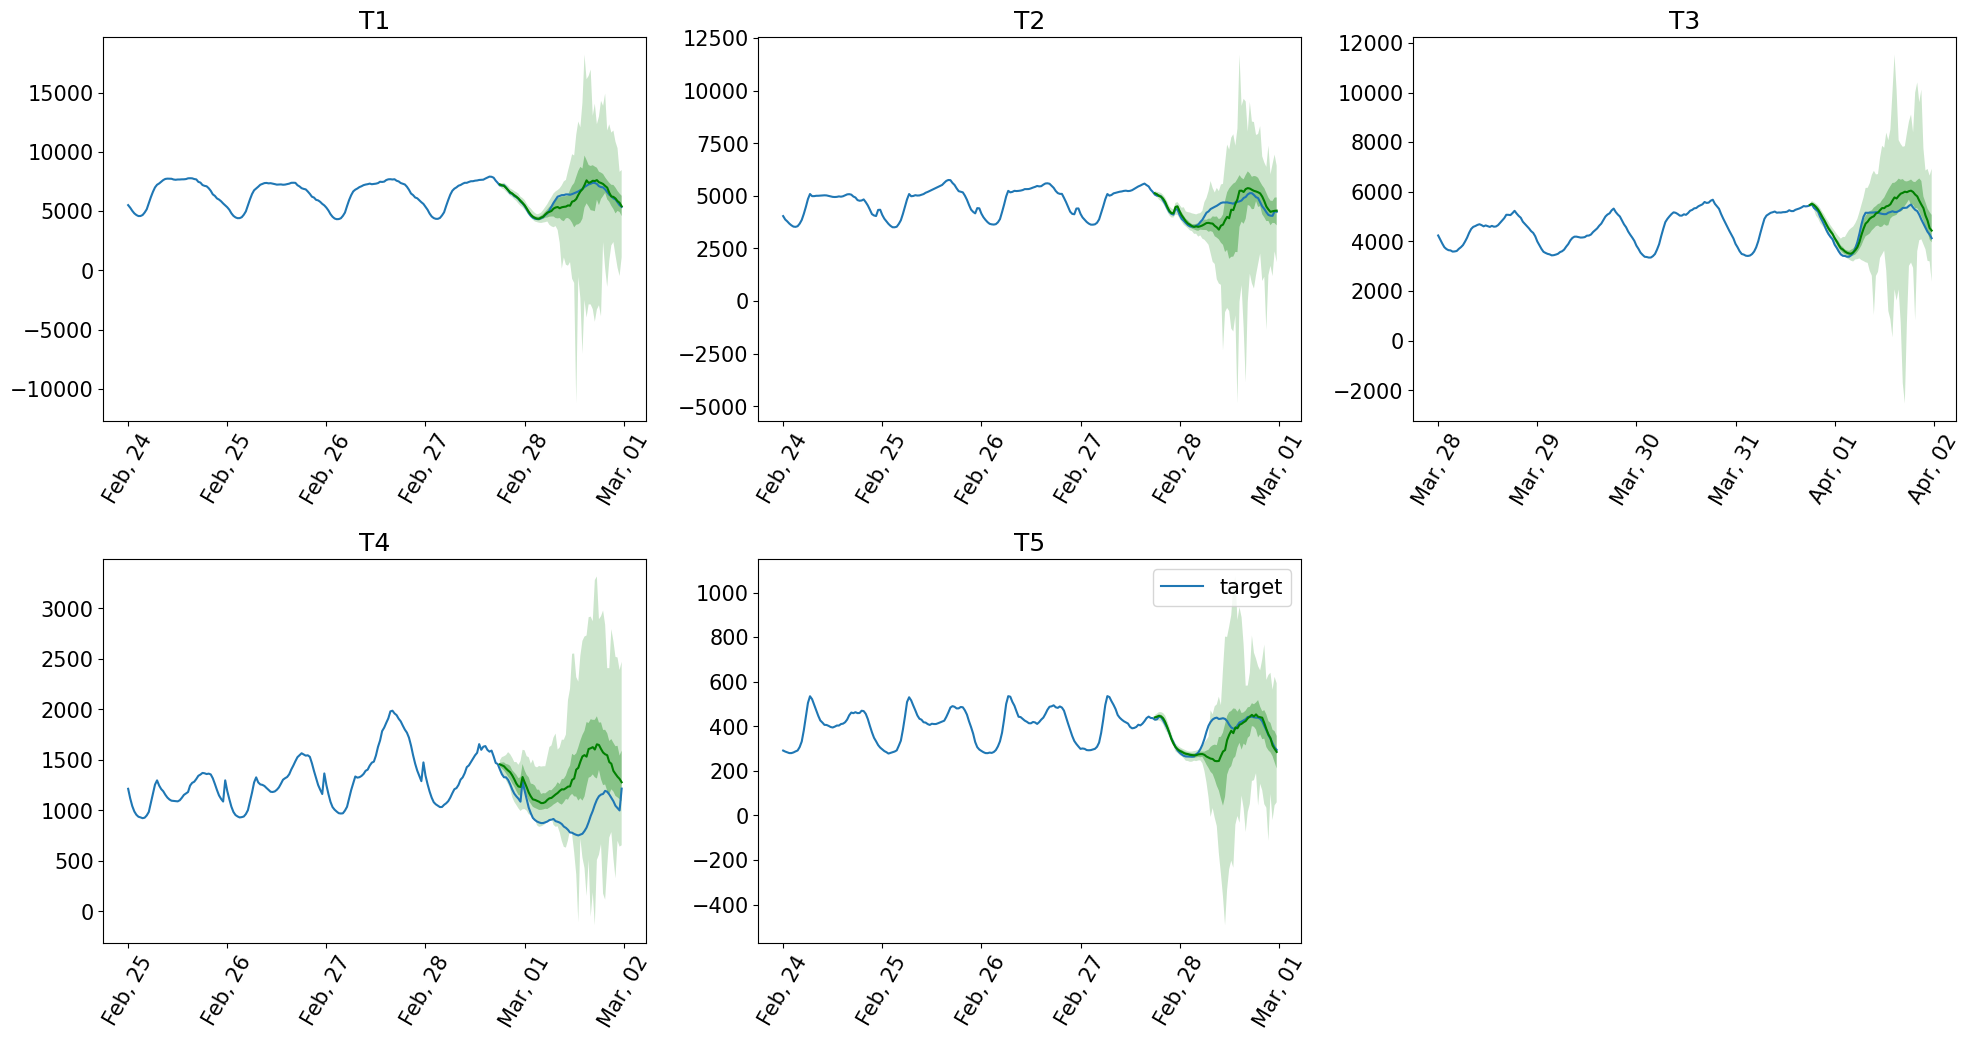

In [41]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In the figure above, we can see that the model made reasonable predictions on the data, although it does have trouble with the fourth series (bottom right of the figure).

Plus, since Lag-Llama implements probabilistic predictions, we also get uncertainty intervals along with the predictions.

Now that we know how to use Lag-Llama for zero-shot forecasting, let’s compare its performance against data-specific models

**Visualizing the zero-shot predictions of Lag-Llama on the Australian Electricity Demand dataset**

**Comparing to TFT and DeepAR**
For consistency, we keep using the GluonTS library and train a TFT and DeepAR models on the dataset to see if they can perform better.

To save some time, we constrain training to five epochs only.

In [42]:
from gluonts.torch import TemporalFusionTransformerEstimator, DeepAREstimator

tft_estimator = TemporalFusionTransformerEstimator(
  prediction_length=prediction_length,
  context_length=context_length,
  freq="30min",
  trainer_kwargs={"max_epochs": 5})

deepar_estimator = DeepAREstimator(
  prediction_length=prediction_length,
  context_length=context_length,
  freq="30min",
  trainer_kwargs={"max_epochs": 5})

In [ ]:
tft_predictor = tft_estimator.train(dataset.train)
deepar_predictor = deepar_estimator.train(dataset.train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                           | Params | In sizes | Out sizes 
---------------------------------------------------------------------------------
0 | model | TemporalFusionTransformerModel | 132 K  | ?        | [1, 9, 60]
---------------------------------------------------------------------------------
132 K     Tr

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 3731.81567 (best 3731.81567), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 2816.75903 (best 2816.75903), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached 2532.98730 (best 2532.98730), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached 2214.95898 (best 2214.95898), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached 2108.09790 (

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 8.09738 (best 8.09738), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 7.03204 (best 7.03204), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=1-step=100.ckpt' as top 1


In [18]:
# Make predictions

tft_forecast_it, tft_ts_it = make_evaluation_predictions(
  dataset=backtest_dataset,
  predictor=tft_predictor)

deepar_forecast_it, deepar_ts_it = make_evaluation_predictions(
  dataset=backtest_dataset,
  predictor=deepar_predictor)

tft_forecasts = list(tft_forecast_it)
tft_tss = list(tft_ts_it)

deepar_forecasts = list(deepar_forecast_it)
deepar_tss = list(deepar_ts_it)

# Get evaluation metrics
tft_agg_metrics, tft_ts_metrics = evaluator(iter(tft_tss), iter(tft_forecasts))
deepar_agg_metrics, deepar_ts_metrics = evaluator(iter(deepar_tss), iter(deepar_forecasts))

Running evaluation: 66it [00:00, 2100.80it/s]
Running evaluation: 66it [00:00, 3121.40it/s]


**Results:**
RMSE(lag_llama) : 481.57
RMSE(TFT) : 272.61
RMSE(DeepAR) : 445.51